In [1]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
random.seed(1993)   # For consistency

In [3]:
def f(x):
    return 3*x**2 - 4*x + 5

f(3.0)

20.0

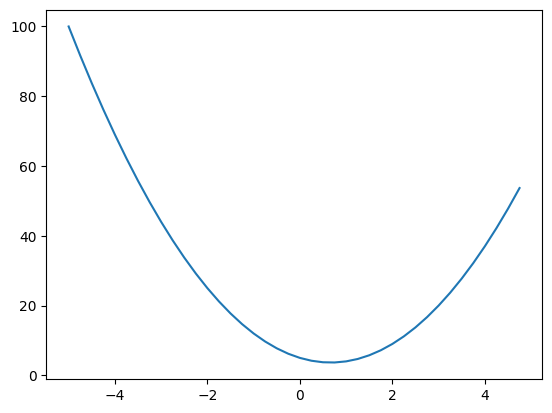

In [4]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

In [5]:
#!pip install graphviz
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
    
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangular ('record') node for it
        dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            # if this value is a result of some operation, create an op node for it
            dot.node(name = uid + n._op, label = n._op)
            # and connect this node to it
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

In [6]:
def trace(root):
    # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

In [7]:
# Now let's add this to value class

class Value:

    def __init__(self, data, _children=(), _op="", label=""):
        self.data = data
        self.grad = 0.0     # grad represents the derrivative of output (say L) wrt to value (say a or f)
        self._prev = set(_children)
        self._backward = lambda: None
        self._op = _op
        self.label = label
    
    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), "+")
        
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad

            # this means the gradient is just copied as it is as 
            # we have seen it happening for addition            
        
        out._backward = _backward

        return out

    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), "*")
        
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad          
        
        out._backward = _backward

        return out

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        out = Value(t, (self, ), "tanh")

        def _backward():
            self.grad += (1 - t**2) * out.grad          
        
        out._backward = _backward

        return out 

    
    def backward(self):
        topo = []
        visited = set()

        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)

        self.grad = 1.0 
        for node in reversed(topo):
            node._backward()


In [8]:
# Currently we cannot do integer addition directly, so, we will make change now
# We will do this for multiply

class Value:

    def __init__(self, data, _children=(), _op="", label=""):
        self.data = data
        self.grad = 0.0     # grad represents the derrivative of output (say L) wrt to value (say a or f)
        self._prev = set(_children)
        self._backward = lambda: None
        self._op = _op
        self.label = label
    
    
    def __repr__(self):
        return f"Value(data={self.data})"

    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)     # now, we can add integer directly
        out = Value(self.data + other.data, (self, other), "+")
        
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad

            # this means the gradient is just copied as it is as 
            # we have seen it happening for addition            
        
        out._backward = _backward

        return out
    
    def __radd__(self, other):
        return self + other

    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), "*")
        
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad          
        
        out._backward = _backward

        return out


    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self,), f'**{other}')

        def _backward():
            self.grad += (other*self.data**(other - 1)) * out.grad
        
        out._backward = _backward

        return out
    

    def __rmul__(self, other):  #other * self
        return self * other

    
    def __truediv__(self, other):
        return self * (other**-1)

    
    def __sub__(self, other):
        return self + (-other)  
    
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), "exp")

        def _backward():
            self.grad += out.data * out.grad     # exp(x) * out.grad
        
        out._backward = _backward
        
        return out


    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        out = Value(t, (self, ), "tanh")

        def _backward():
            self.grad += (1 - t**2) * out.grad          
        
        out._backward = _backward

        return out 

    
    def backward(self):
        topo = []
        visited = set()

        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        
        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()


In [9]:
a = Value(2.0)
b = Value(4.0)

print(a+1)
print(1+a)

print(a*2)
print(a/2)
print(a/b)

print(b**2)

print(b.exp())

Value(data=3.0)
Value(data=3.0)
Value(data=4.0)
Value(data=1.0)
Value(data=0.5)
Value(data=16.0)
Value(data=54.598150033144236)


**Division**

a / b

a * (1/b)

a * (b**-1)

Let's make:
x**k


In [10]:
a = Value(2.0)
b = Value(4.0)

a/b


Value(data=0.5)

## Breaking down tanh

In [11]:
# Let's see if everything works
# inputs
x1 = Value(2.0, label="x1")
x2 = Value(0.0, label="x2")

# Weights
w1 = Value(-3.0, label="w1")
w2 = Value(1.0, label="w2")

# Bias of a neuron
b = Value(6.88137358701954432, label="b")

# from figure we can see
# x1*w1 + x2*w2 + b

x1w1 = x1*w1; x1w1.label ="x1*w1"
x2w2 = x2*w2; x2w2.label ="x2*w2"

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = "x1w1 + x2w2"

n = x1w1x2w2 + b; n.label = "n" # Without activation function now

#o = n.tanh(); o.label = "output"
# ---------- tanh break-up ----------
e = (2*n).exp()
o = (e - 1) / (e + 1); o.label = "output"

# ---------- tanh break-up ----------


o.backward()

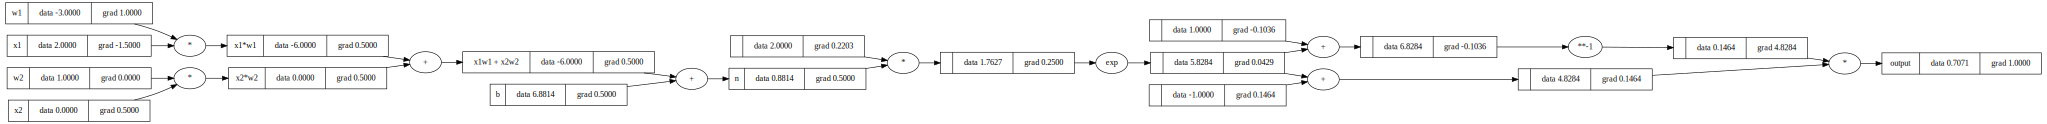

In [12]:
draw_dot(o)

The outputs of this resembles exactly the output if we directly use tanh fucntion. So, it doesn't matter how we implement operations. 

All that matters is we can correctly calulate the forward and backward pass.

#### Now the same thing is PyTorch

In [13]:
import torch

In [14]:
x1 = torch.Tensor([2.0]).double()                ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()               ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()  ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

# The result is exactly the same

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


# Building Neural Net(s) now

In [15]:
class Neuron:

    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))

    def __call__(self, x):
        # w*x +b    # w*x is a dot product
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b )
        out = act.tanh()
        return out

    def parameters(self):
        return self.w + [self.b]


class Layer:

    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

    def parameters(self):       
        return [p for n in self.neurons for p in n.parameters()]

        # for neuron in self.neurons:
        #     ps = neuron.parameters()
        #     params.extend(ps)
        # return params


class MLP:
    
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [16]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=0.007657120625740258)

In [17]:
len(n.parameters())

41

In [18]:
#draw_dot(n(x))

In [19]:
# Examples for training
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

In [20]:
ypred =[n(x) for x in xs]
ypred

[Value(data=0.007657120625740258),
 Value(data=0.9629698232963938),
 Value(data=0.6722963345252638),
 Value(data=-0.24414394993705751)]

In [21]:
# We wil calculate the loss to measure the correcteness of the prediction: how well the neural net is performing
loss = sum([(yout - ygt)**2 for ygt, yout in zip(ys, ypred)])
loss

Value(data=9.182464116048688)

In [22]:
# We want the loss to be low
loss.backward()

In [23]:
n.layers[0].neurons[0].w[0].grad    # If the gradient is negative, that means by increasing the weight of this neuron, the loss will go down

# We have this information for all of our neurons and their parameters

0.17473429586587344

In [24]:
print('w1 grad', n.layers[0].neurons[0].w[0].grad)
print('w1 data', n.layers[0].neurons[0].w[0].data)

w1 grad 0.17473429586587344
w1 data -0.03862055212227311


In [25]:
# we will itirate through all the parameters

for p in n.parameters():
    p.data += -0.01 * p.grad    # if gradient is negative, we increase the weight, if it is positive, we decrease the weight

In [26]:
# after the change
print('w1 grad', n.layers[0].neurons[0].w[0].grad)
print('w1 data', n.layers[0].neurons[0].w[0].data)

w1 grad 0.17473429586587344
w1 data -0.040367895080931845


In [27]:
# Now we recalculate the loss   # we expecct it to be lower
ypred =[n(x) for x in xs]
loss = sum([(yout - ygt)**2 for ygt, yout in zip(ys, ypred)])
loss

# It is lower

# You won't get the exact same results as I did, but you should get a loss that is lower than the initial loss (it was randomly initialized) : 
# but now you will do because i seeded the random number generator

Value(data=8.607967674232228)

In [28]:
# Now we will do backward pass
loss.backward()

In [29]:
for p in n.parameters():
    p.data += -0.1 * p.grad

In [30]:
ypred =[n(x) for x in xs]
loss = sum([(yout - ygt)**2 for ygt, yout in zip(ys, ypred)])
loss

# Now the loss should decrease more

Value(data=6.247012816219952)

This is gradient descent, we are doing forward pass, backward pass and then update. As a result neural net is improving its predictions<>

In [31]:
# Let's now do this a few more time with an increased learning rate

for e in range(5):
    ypred =[n(x) for x in xs]
    loss = sum([(yout - ygt)**2 for ygt, yout in zip(ys, ypred)])
    loss.backward()
    for p in n.parameters():
        p.data += -0.1 * p.grad

ypred

# You can see the output is getting closer to the desired output

[Value(data=0.8009931947462453),
 Value(data=-0.6030405624037342),
 Value(data=0.7932559750217888),
 Value(data=0.7905048504993913)]

In [32]:
# the loss here is:
loss

# see it is very low now
# loss = Value(data=3.1391947868174866e-07)

Value(data=3.4568357132496788)

In [33]:
# Let's look at the parameters
# There are a set of trained neural net parameters that will give us the desired output

#n.parameters()

### Let's do it in a proper way from begining like we do in regular trainings

In [34]:
# Data
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

In [35]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])

learning_rate = 0.05

for e in range(20):
    # forward pass
    ypred =[n(x) for x in xs]
    loss = sum([(yout - ygt)**2 for ygt, yout in zip(ys, ypred)])
    
    # backward pass
    loss.backward()

    # update
    for p in n.parameters():
        p.data += -learning_rate * p.grad
    
    # print every
    if e % 2 == 0:
        print("Current step: ", e, "Loss: ", loss.data)

# After last step of training let's predict again
ypred =[n(x) for x in xs]
print(ypred)

Current step:  0 Loss:  8.590244752121581
Current step:  2 Loss:  3.251279565120799
Current step:  4 Loss:  0.4314166532029969
Current step:  6 Loss:  0.008903970131844198
Current step:  8 Loss:  0.00017030867419075724
Current step:  10 Loss:  6.909809892444565e-06
Current step:  12 Loss:  3.79564352360394e-07
Current step:  14 Loss:  2.3918872973270876e-08
Current step:  16 Loss:  1.6092511096719524e-09
Current step:  18 Loss:  1.3445988501866946e-06
[Value(data=0.9999971000178582), Value(data=-0.9999999999981305), Value(data=-0.999999999998144), Value(data=0.9999981856078193)]


In [36]:
# There is a very common bug in the code above. We are not setting the gradients back to zero. lol
# The only reason previous one was working because the data is very simple.
# Also you can see the number of epochs has increased by a lot. Gradients are being set back to zero.
# Previously they were being added.
# Let's fix that!

x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])

learning_rate = 0.05

# We are doing gradient descent here
for e in range(1000):
    # forward pass
    ypred =[n(x) for x in xs]
    loss = sum([(yout - ygt)**2 for ygt, yout in zip(ys, ypred)])
    
    # zero grad
    for p in n.parameters():
        p.grad = 0.0      # we need to set the gradients back to zero, otherwise they will accumulate
    
    # backward pass
    loss.backward()

    # update
    for p in n.parameters():
        p.data += -learning_rate * p.grad
    
    # print every
    if e % 2 == 0:
        print("Current step: ", e, "Loss: ", loss.data)

# After last step of training let's predict again
ypred =[n(x) for x in xs]
print(ypred)


Current step:  0 Loss:  3.0671681764088587
Current step:  2 Loss:  0.7522797144376534
Current step:  4 Loss:  0.21049320414541034
Current step:  6 Loss:  0.12931817259939735
Current step:  8 Loss:  0.09173860850980789
Current step:  10 Loss:  0.07046366092766423
Current step:  12 Loss:  0.05690191664948921
Current step:  14 Loss:  0.04755552992867856
Current step:  16 Loss:  0.04074910543584072
Current step:  18 Loss:  0.03558485523377747
Current step:  20 Loss:  0.03154041675170391
Current step:  22 Loss:  0.028292096705550128
Current step:  24 Loss:  0.025629064823938723
Current step:  26 Loss:  0.023408339828180122
Current step:  28 Loss:  0.021529657545075617
Current step:  30 Loss:  0.019920702795380423
Current step:  32 Loss:  0.018528051621906523
Current step:  34 Loss:  0.01731141003069202
Current step:  36 Loss:  0.016239832977886108
Current step:  38 Loss:  0.015289174466104255
Current step:  40 Loss:  0.014440326294789117
Current step:  42 Loss:  0.013677975530100375
Current